<a href="https://colab.research.google.com/github/ThinkingBeyond/BeyondAI-2024/blob/main/emeka/Cancer_Dataset_Code_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code compares Multi-Layer Perceptron(MLP) with Kolmogorov Arnold Network (KAN) on the Wisconsin Breast Cancer Dataset.
Each model is run with one hidden layer, tested over different width of the layer.
The code test each model over a moderate width(27 neurons per layer), a larger width(64 neurons per layer) and a smaller width(18 neurons per layer)
GridSearchCV was used by both models to calculate the best parameters and hyperparameters for the number of layer and neurons per layer chosen

The result shows smooth covergence between each of the models,MLP had a very quick execution time and minumum loss unlike the KAN which took longer time to be executed and had a higher loss. Though, both models had similar accuracy score over the unseen data.


##Import Necessary Libraries

In [1]:
!pip install git+https://github.com/KindXiaoming/pykan.git
!apt-get install python3.10-venv
!python3.10 -m venv .venv310
!source .venv310/bin/activate
!python --version  # 3.10.12
!pip install scikit-learn==1.6.0 pandas==2.2.2 matplotlib==3.8.0 torch==2.5.1+cu121 numpy==1.26.4
!pip install git+https://github.com/trevorstephens/gplearn.git

  Cloning https://github.com/KindXiaoming/pykan.git to /tmp/pip-req-build-21vwrm42
  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git /tmp/pip-req-build-21vwrm42
  Resolved https://github.com/KindXiaoming/pykan.git to commit f871c26d4df788ec1ba309c2c9c1803d82606b06
  Preparing metadata (setup.py) ... done
  Created wheel for pykan: filename=pykan-0.2.8-py3-none-any.whl size=78208 sha256=2588868bf99eb288a347117698e7bd30e9aa1a54d3c4b0f7bbbeaf076602ce2e
  Stored in directory: /tmp/pip-ephem-wheel-cache-ct7cab38/wheels/47/ca/5a/98124e020f3119f51c17f78738c621c140b7aa803b0feda76e
Successfully built pykan
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-pip-whl python3-setuptools-whl
The following NEW packages will be installed:
  python3-pip-whl python3-setuptools-whl python3.10-venv
0 upgraded, 3 newly installed, 0 to remove and 49 not 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from kan import *
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, classification_report
from sklearn.preprocessing import StandardScaler
from gplearn.genetic import SymbolicRegressor, SymbolicTransformer
from sklearn.utils.estimator_checks import check_estimator
import time
import warnings
warnings.filterwarnings("ignore")

##Models
The models are being called here along with the default number of layers and hyperparameter

In [3]:
#MLP Model
mlp = MLPClassifier()#default parameters
#KAN Model
kan = KAN(width=[2,2,1])# should be adjusted based on dataset

checkpoint directory created: ./model
saving model version 0.0


#Functions
All the functions to be used for calculating the accuracies, losses, precision, recall, confusion matrix. The function to plot the graph is also written here.

##Model Functions

In [4]:
def MLP_run(mlp,X_train,y_train,X_test,y_test,epochs):
  y_train = torch.tensor(y_train, dtype=torch.float32)
  y_test = torch.tensor(y_test, dtype=torch.float32)
  train_accuracies,test_accuracies = [],[]
  train_losses,test_losses = [],[]
  criterion = nn.MSELoss()
  start_time = time.time()

  for epoch in range(epochs):
    mlp.partial_fit(X_train, y_train, classes=np.unique(y_train))
    y_pred_train = mlp.predict(X_train)
    train_acc = accuracy_score(y_train, torch.tensor(y_pred_train))
    train_loss = criterion(torch.tensor(y_pred_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    train_accuracies.append(train_acc)
    train_losses.append(train_loss.item())
    if (epoch + 1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}],MLP Train Loss: {train_loss.item():.4f}, MLP Train Accuracy: {train_acc:.4f}')

  for epoch in range(epochs):
    y_pred_test = mlp.predict(X_test)
    test_acc = accuracy_score(torch.tensor(y_test), torch.tensor(y_pred_test))
    test_loss = criterion(torch.tensor(y_pred_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
    test_accuracies.append(test_acc)
    test_losses.append(test_loss.item())
    if (epoch + 1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}],MLP Test Loss: {test_loss.item():.4f}, MLP Test Accuracy: {test_acc:.4f}')
  end_time = time.time()
  MLP_Execution_Time = end_time - start_time
  return train_accuracies,test_accuracies,train_losses,test_losses,MLP_Execution_Time


def KAN_run(model,X_train,y_train,X_test,y_test,epochs):
  y_train = torch.tensor(y_train, dtype=torch.long)
  y_test = torch.tensor(y_test, dtype=torch.long)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
  loss_fn = nn.CrossEntropyLoss()
  kan_train_accuracy = []
  kan_test_accuracy = []
  kan_train_loss = []
  kan_test_loss = []
  starting_time = time.time()

  for epoch in range(epochs): #training
    optimizer.zero_grad()
    outputs = model(X_train)
    predicted = torch.argmax(outputs, dim=1)
    train_accuracy = accuracy_score(y_train, predicted)
    train_loss = loss_fn(outputs, y_train)
    train_loss.backward()
    optimizer.step()
    kan_train_accuracy.append(train_accuracy)
    kan_train_loss.append(train_loss.item())
    if (epoch + 1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}],KAN Train Loss: {train_loss.item():.4f}, KAN Train Accuracy: {train_accuracy:.4f}')

  for epoch in range(epochs): # testing
    predicted = model(x_test_tensor)
    test_accuracy = accuracy_score(y_test_tensor, predicted.argmax(1))
    test_loss = loss_fn(predicted, y_test_tensor)
    kan_test_accuracy.append(test_accuracy)
    kan_test_loss.append(test_loss.item())
    if (epoch + 1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}],KAN Test Loss: {test_loss.item():.4f},KAN Test Accuracy: {test_accuracy:.4f}')
  final_time = time.time()
  KAN_Execution_Time = final_time - starting_time
  return kan_train_accuracy, kan_test_accuracy, kan_train_loss, kan_test_loss, KAN_Execution_Time

##Model Run Function

In [5]:
def run_models(mlp_model,kan_model,epochs):
  mlp_model_run = MLP_run(mlp_model,x_train_tensor,y_train_tensor,x_test_tensor,y_test_tensor,epochs)
  mlp_metrics = [mlp_model_run[0],mlp_model_run[1],mlp_model_run[2],mlp_model_run[3]]
  print(f'MLP Execution time: {mlp_model_run[4]:.2f} seconds')

  print()

  kan_model_run = KAN_run(kan_model,x_train_tensor,y_train_tensor,x_test_tensor,y_test_tensor,epochs)
  kan_metrics = [kan_model_run[0],kan_model_run[1],kan_model_run[2],kan_model_run[3]]
  print(f'KAN Execution time: {kan_model_run[4]:.2f} seconds')
  return mlp_metrics,kan_metrics

##Plot Function

In [6]:
def plot_comparison_over_epochs(mlp_metrics,kan_metrics, num_epochs):
    epochs = range(1, num_epochs + 1)
    mlp_train_acc, mlp_test_acc, mlp_train_loss, mlp_test_loss = mlp_metrics
    kan_train_acc, kan_test_acc, kan_train_loss, kan_test_loss = kan_metrics
    plt.figure(figsize=(10,6))

    # Graph of Train Accuracy for both models over number of epochs
    plt.subplot(121)
    plt.plot(epochs, mlp_train_acc, label='MLP Train Accuracy',color='blue',marker='*')
    plt.plot(epochs, kan_train_acc, label='KAN Train Accuracy',color='red',marker='*')
    plt.plot(epochs, mlp_test_acc, label='MLP Test Accuracy',color='green',marker='*')
    plt.plot(epochs, kan_test_acc, label='KAN Test Accuracy',color='yellow',marker='*')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('MLP and KAN Train and Test Accuracy Over Epochs')
    plt.legend()

    # Graph of loss of both models during training
    plt.subplot(122)
    plt.plot(epochs, mlp_train_loss, label='MLP Train Loss',color='blue',marker='*')
    plt.plot(epochs, kan_train_loss, label='KAN Train Loss',color='red',marker='*')
    plt.ylim(0, 1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

##Comparison Criteria Functions

In [7]:
def criteria_comparison(mlp,kan,x_test_tensor,y_test_tensor):
  mlp_classification= classification_report(y_test_tensor, mlp.predict(x_test_tensor))
  kan_classification = classification_report(y_test_tensor, kan(x_test_tensor).argmax(1))
  mlp_confusion = confusion_matrix(y_test_tensor, mlp.predict(x_test_tensor))
  kan_confusion = confusion_matrix(y_test_tensor, kan(x_test_tensor).argmax(1))
  print(f'MLP Classification Report:\n{mlp_classification}')
  print(f'MLP Confusion Matrix:\n{mlp_confusion}')
  print(f'KAN Classification Report:\n{kan_classification}')
  print(f'KAN Confusion Matrix:\n{kan_confusion}')

##KAN Hyperparameter Tunning Function

In [8]:
class KANWrapper:
    def __init__(self, width, grid=3, k=2, noise_scale=0.1, mult_arity=2, seed=123):
        self.width = width
        self.grid = grid
        self.k = k
        self.noise_scale = noise_scale
        self.mult_arity = mult_arity
        self.seed = seed
        self.model = KAN(width=width, grid=grid, k=k, noise_scale=noise_scale, mult_arity=mult_arity, seed=seed)
    def fit(self, X, y):
        self.model.update_grid_from_samples(torch.tensor(X, dtype=torch.float32))  # Assuming X is a NumPy array
        return self
    def predict(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32)  # Assuming X is a NumPy array
        outputs = self.model(X_tensor)
        return outputs.argmax(1).numpy()
    def get_params(self, deep=True):
        return {"width": self.width,
                "grid": self.grid,
                "k": self.k,
                "noise_scale": self.noise_scale,
                "mult_arity": self.mult_arity,
                "seed": self.seed
               }
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        self.model = KAN(width=self.width, grid=self.grid, k=self.k, noise_scale=self.noise_scale, mult_arity=self.mult_arity, seed=self.seed)
        return self

def kan_hyperparameter(kan_tune,x_train_tensor,y_train_tensor):
  param_grid_kan = {'grid':[4,5,6],
                      'k':[2,3,4],
                      'noise_scale':[0.1,0.01,0.001,0.2]}
  clfkan = GridSearchCV(kan_tune, param_grid_kan, cv=5, scoring='accuracy')
  clfkan.fit(x_train_tensor.numpy(), y_train_tensor.numpy())
  return f"Best parameters: {clfkan.best_params_}"

#Dataset
The dataset to be used for the analysis is loaded here as well as preparation for the dataset using standard scaler(to make every feature have a mean of 0 and a standard deviation of 1) for faster convergence and imporved performance

##Load Dataset

In [9]:
url_wisconsin_breast_cancer = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
df = pd.read_csv(url_wisconsin_breast_cancer, header=None)
df[10]=df[10].replace(2,0)
df[10]=df[10].replace(4,1)
x = df.drop([6, 10], axis=1).values
y = df[10].values

##Prepare Dataset

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)
# Converting data to tensors
x_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train)
x_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test)

# Runing the model
Running the models over 100 epochs with different neurons per layer for MLP and KAN

Plotting the accuracies and loss over epochs

Calculating other comparison criteria




In [11]:
epochs = 100

### Model Run with 1 hidden layer of 27 neurons

In [12]:
# Hyperparmeter Tunning for the hidden layer
param_grid_mlp_0 = {'hidden_layer_sizes': [(27)],
    'activation': ['relu', 'tanh','logistics'],
    'alpha':[0.01,0.1],
    'learning_rate_init':[0.001,0.01,0.1,1],
    'solver':['adam','sgd'],
    'learning_rate':['adaptive','constant']}
mlp_0 = MLPClassifier(max_iter=1000, random_state=123)
clfmlp_0 = GridSearchCV(mlp_0, param_grid_mlp_0, cv=5, scoring='accuracy')
clfmlp_0.fit(x_train_tensor.numpy(), y_train_tensor.numpy())
print(f"Best parameters: {clfmlp_0.best_params_}")

Best parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 27, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'solver': 'adam'}


In [13]:
# # Remove comment to run the code using ctrl + /
# kan_tune_0 = KANWrapper(width=[9,27,2], seed=123)
# print(kan_hyperparameter( kan_tune_0,x_train_tensor,y_train_tensor))
# # Result:  Best parameters: {'grid': 5, 'k': 2, 'noise_scale': 0.001}

checkpoint directory created: ./model
saving model version 0.0
Epoch [10/100],MLP Train Loss: 0.0477, MLP Train Accuracy: 0.9523
Epoch [20/100],MLP Train Loss: 0.0430, MLP Train Accuracy: 0.9570
Epoch [30/100],MLP Train Loss: 0.0430, MLP Train Accuracy: 0.9570
Epoch [40/100],MLP Train Loss: 0.0430, MLP Train Accuracy: 0.9570
Epoch [50/100],MLP Train Loss: 0.0430, MLP Train Accuracy: 0.9570
Epoch [60/100],MLP Train Loss: 0.0430, MLP Train Accuracy: 0.9570
Epoch [70/100],MLP Train Loss: 0.0430, MLP Train Accuracy: 0.9570
Epoch [80/100],MLP Train Loss: 0.0430, MLP Train Accuracy: 0.9570
Epoch [90/100],MLP Train Loss: 0.0430, MLP Train Accuracy: 0.9570
Epoch [100/100],MLP Train Loss: 0.0430, MLP Train Accuracy: 0.9570
Epoch [10/100],MLP Test Loss: 0.0286, MLP Test Accuracy: 0.9714
Epoch [20/100],MLP Test Loss: 0.0286, MLP Test Accuracy: 0.9714
Epoch [30/100],MLP Test Loss: 0.0286, MLP Test Accuracy: 0.9714
Epoch [40/100],MLP Test Loss: 0.0286, MLP Test Accuracy: 0.9714
Epoch [50/100],MLP T

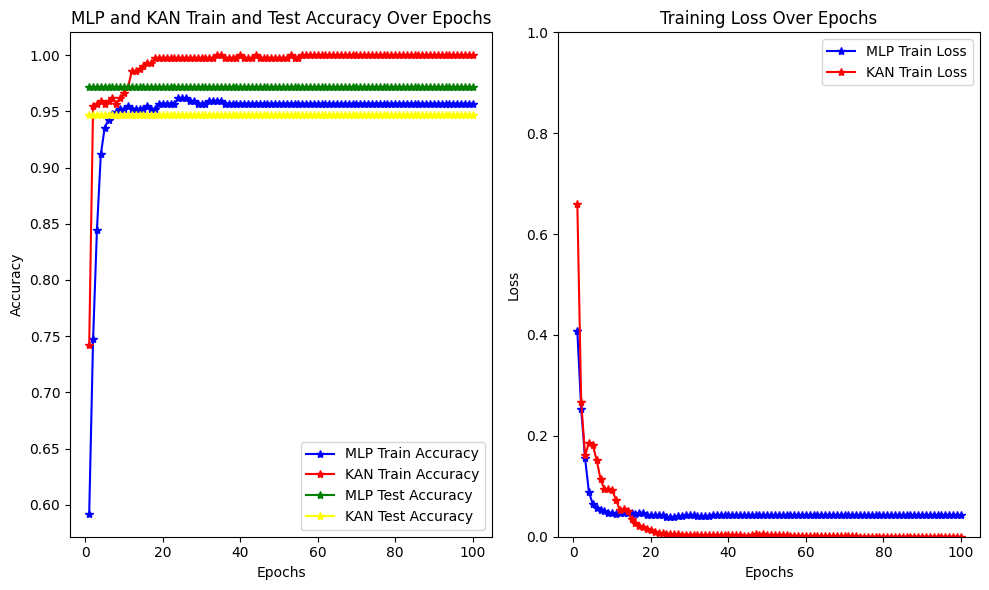

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       185
           1       0.95      0.97      0.96        95

    accuracy                           0.97       280
   macro avg       0.97      0.97      0.97       280
weighted avg       0.97      0.97      0.97       280

MLP Confusion Matrix:
[[180   5]
 [  3  92]]
KAN Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       185
           1       0.94      0.89      0.92        95

    accuracy                           0.95       280
   macro avg       0.95      0.93      0.94       280
weighted avg       0.95      0.95      0.95       280

KAN Confusion Matrix:
[[180   5]
 [ 10  85]]


In [14]:
mlp_2 = MLPClassifier(hidden_layer_sizes=(27),
                    max_iter=1000,
                    activation='relu',
                    learning_rate='adaptive',
                    learning_rate_init=0.001,
                    alpha= 0.01,
                    solver='adam',
                    random_state=123,
                    verbose = False)
kan_2= KAN(width=[9,27,2],
           grid=5,
           k=2,
           noise_scale=0.001,
           seed=123)

mlp_metrics_2,kan_metrics_2 = run_models(mlp_2,kan_2,epochs)
plot_comparison_over_epochs(mlp_metrics_2, kan_metrics_2,epochs)
mlp_2.fit(x_train_tensor, y_train_tensor)
criteria_comparison(mlp_2,kan_2,x_test_tensor,y_test_tensor)

### Model Run with 1 hidden layer1 of 64 neurons

In [15]:
# Hyperparameter Tunning for the hidden layer
param_grid_mlp_1 = {'hidden_layer_sizes': [(64)],
    'activation': ['relu', 'tanh','logistics'],
    'alpha':[0.01,0.1],
    'learning_rate_init':[0.001,0.01,0.1,1],
    'solver':['adam','sgd'],
    'learning_rate':['adaptive','constant']}
mlp_1 = MLPClassifier(max_iter=1000, random_state=123)
clfmlp_1 = GridSearchCV(mlp_1, param_grid_mlp_1, cv=5, scoring='accuracy')
clfmlp_1.fit(x_train_tensor.numpy(), y_train_tensor.numpy())
print(f"Best parameters: {clfmlp_1.best_params_}")

Best parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 64, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'solver': 'sgd'}


In [16]:
# # Remove comment to run the code using ctrl + /
# kan_tune_1 = KANWrapper(width=[9,64,2], seed=123)
# print(kan_hyperparameter(kan_tune_1,x_train_tensor,y_train_tensor))
# # Result: Best parameters: {'grid': 6, 'k': 2, 'noise_scale': 0.001}

checkpoint directory created: ./model
saving model version 0.0
Epoch [10/100],MLP Train Loss: 0.4678, MLP Train Accuracy: 0.5322
Epoch [20/100],MLP Train Loss: 0.0788, MLP Train Accuracy: 0.9212
Epoch [30/100],MLP Train Loss: 0.0477, MLP Train Accuracy: 0.9523
Epoch [40/100],MLP Train Loss: 0.0453, MLP Train Accuracy: 0.9547
Epoch [50/100],MLP Train Loss: 0.0430, MLP Train Accuracy: 0.9570
Epoch [60/100],MLP Train Loss: 0.0430, MLP Train Accuracy: 0.9570
Epoch [70/100],MLP Train Loss: 0.0430, MLP Train Accuracy: 0.9570
Epoch [80/100],MLP Train Loss: 0.0477, MLP Train Accuracy: 0.9523
Epoch [90/100],MLP Train Loss: 0.0453, MLP Train Accuracy: 0.9547
Epoch [100/100],MLP Train Loss: 0.0453, MLP Train Accuracy: 0.9547
Epoch [10/100],MLP Test Loss: 0.0286, MLP Test Accuracy: 0.9714
Epoch [20/100],MLP Test Loss: 0.0286, MLP Test Accuracy: 0.9714
Epoch [30/100],MLP Test Loss: 0.0286, MLP Test Accuracy: 0.9714
Epoch [40/100],MLP Test Loss: 0.0286, MLP Test Accuracy: 0.9714
Epoch [50/100],MLP T

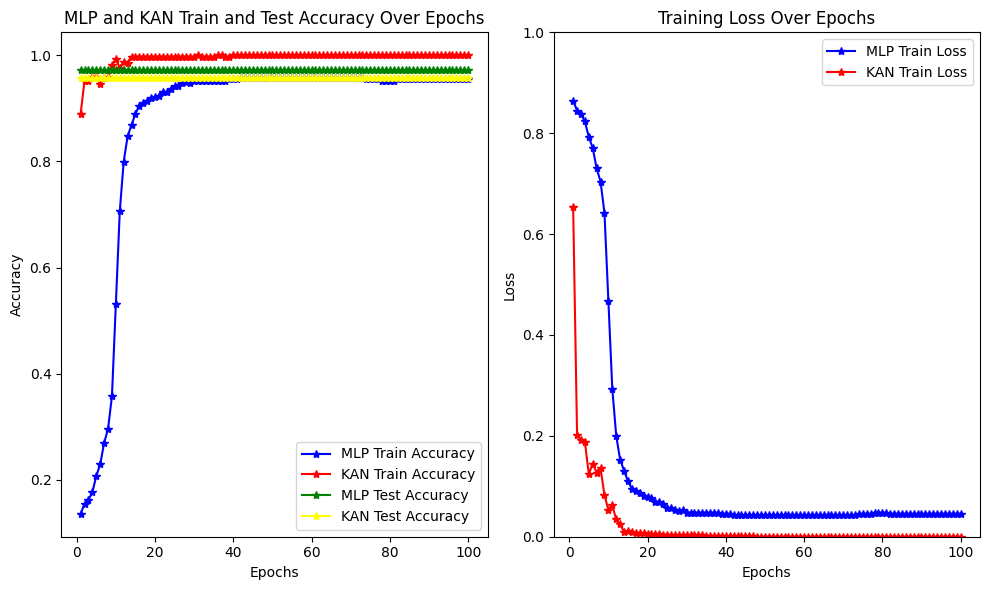

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       185
           1       0.95      0.96      0.95        95

    accuracy                           0.97       280
   macro avg       0.96      0.97      0.96       280
weighted avg       0.97      0.97      0.97       280

MLP Confusion Matrix:
[[180   5]
 [  4  91]]
KAN Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       185
           1       0.94      0.94      0.94        95

    accuracy                           0.96       280
   macro avg       0.95      0.95      0.95       280
weighted avg       0.96      0.96      0.96       280

KAN Confusion Matrix:
[[179   6]
 [  6  89]]


In [17]:
mlp_1 = MLPClassifier(hidden_layer_sizes=(64),
                    max_iter=1000,
                    activation='relu',
                    learning_rate_init=0.001,
                    learning_rate='adaptive',
                    alpha= 0.01,
                    solver='sgd',
                    random_state=123,
                    verbose = False)
kan_1= KAN(width=[9,64,2],
           grid=6,
           k=2,
           noise_scale=0.001,
           seed=123)

mlp_metrics_1,kan_metrics_1 = run_models(mlp_1,kan_1,epochs)
plot_comparison_over_epochs(mlp_metrics_1, kan_metrics_1,epochs)
mlp_1.fit(x_train_tensor, y_train_tensor)
criteria_comparison(mlp_1,kan_1,x_test_tensor,y_test_tensor)

### Model Run with 1 hidden layer of 18 neuron

In [18]:
# Hyperparameter Tunning for the hidden layer
param_grid_mlp_2 = {'hidden_layer_sizes': [(18)],
    'activation': ['relu', 'tanh','logistics'],
    'alpha':[0.01,0.1],
    'learning_rate_init':[0.001,0.01,0.1,1],
    'solver':['adam','sgd'],
    'learning_rate':['adaptive','constant']}
mlp_2 = MLPClassifier(max_iter=1000, random_state=123)
clfmlp_2 = GridSearchCV(mlp_2, param_grid_mlp_2, cv=5, scoring='accuracy')
clfmlp_2.fit(x_train_tensor.numpy(), y_train_tensor.numpy())
print(f"Best parameters: {clfmlp_2.best_params_}")

Best parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 18, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'solver': 'sgd'}


In [19]:
# # Remove comment to run the code using ctrl + /
# kan_tune_2 = KANWrapper(width=[9,18,2], seed=123)
# print(kan_hyperparameter(kan_tune_2,x_train_tensor,y_train_tensor))
# # Result:  Best parameters: {'grid': 5, 'k': 2, 'noise_scale': 0.01}

checkpoint directory created: ./model
saving model version 0.0
Epoch [10/100],MLP Train Loss: 0.1002, MLP Train Accuracy: 0.8998
Epoch [20/100],MLP Train Loss: 0.0621, MLP Train Accuracy: 0.9379
Epoch [30/100],MLP Train Loss: 0.0453, MLP Train Accuracy: 0.9547
Epoch [40/100],MLP Train Loss: 0.0477, MLP Train Accuracy: 0.9523
Epoch [50/100],MLP Train Loss: 0.0430, MLP Train Accuracy: 0.9570
Epoch [60/100],MLP Train Loss: 0.0430, MLP Train Accuracy: 0.9570
Epoch [70/100],MLP Train Loss: 0.0430, MLP Train Accuracy: 0.9570
Epoch [80/100],MLP Train Loss: 0.0430, MLP Train Accuracy: 0.9570
Epoch [90/100],MLP Train Loss: 0.0430, MLP Train Accuracy: 0.9570
Epoch [100/100],MLP Train Loss: 0.0430, MLP Train Accuracy: 0.9570
Epoch [10/100],MLP Test Loss: 0.0357, MLP Test Accuracy: 0.9643
Epoch [20/100],MLP Test Loss: 0.0357, MLP Test Accuracy: 0.9643
Epoch [30/100],MLP Test Loss: 0.0357, MLP Test Accuracy: 0.9643
Epoch [40/100],MLP Test Loss: 0.0357, MLP Test Accuracy: 0.9643
Epoch [50/100],MLP T

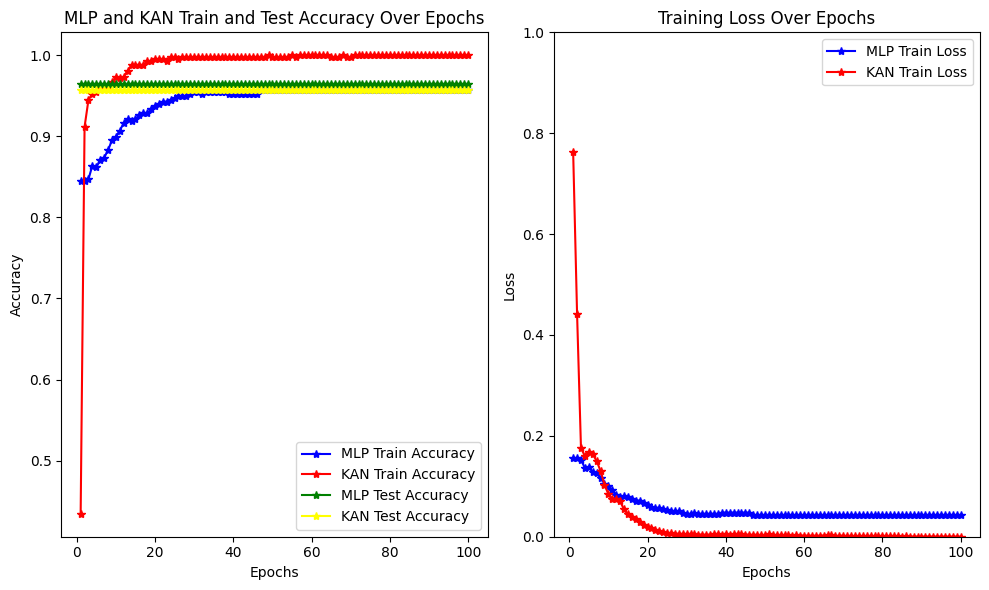

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       185
           1       0.95      0.96      0.95        95

    accuracy                           0.97       280
   macro avg       0.96      0.97      0.96       280
weighted avg       0.97      0.97      0.97       280

MLP Confusion Matrix:
[[180   5]
 [  4  91]]
KAN Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       185
           1       0.94      0.94      0.94        95

    accuracy                           0.96       280
   macro avg       0.95      0.95      0.95       280
weighted avg       0.96      0.96      0.96       280

KAN Confusion Matrix:
[[179   6]
 [  6  89]]


In [21]:
mlp_2 = MLPClassifier(hidden_layer_sizes=(18),
                    max_iter=1000,
                    activation='relu',
                    learning_rate='adaptive',
                    learning_rate_init=0.001,
                    alpha= 0.01,
                    solver='sgd',
                    random_state=123,
                    verbose = False)
kan_2= KAN(width=[9,18,2],
           grid=5,
           k=2,
           noise_scale=0.01,
           seed=123)

mlp_metrics_2,kan_metrics_2 = run_models(mlp_2,kan_2,epochs)
plot_comparison_over_epochs(mlp_metrics_2, kan_metrics_2,epochs)
mlp_2.fit(x_train_tensor, y_train_tensor)
criteria_comparison(mlp_2,kan_2,x_test_tensor,y_test_tensor)